## Estabelecendo conexão com API do kaggle

In [ ]:
# Install Kaggle library
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 8.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=aae08152a30434f931893071ecc885de1f7bb3c9fae618c35e9d9bc93855f153
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
# Colab library to upload files to notebook
from google.colab import files

# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!ls -la /root

total 60
drwx------ 1 root root 4096 Feb  9 12:56 .
drwxr-xr-x 1 root root 4096 Feb  9 12:56 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Feb  9 12:56 .cache
drwxr-xr-x 1 root root 4096 Feb  5 15:41 .config
drwxr-xr-x 3 root root 4096 Feb  5 15:13 .gsutil
drwxr-xr-x 5 root root 4096 Feb  5 15:41 .ipython
drwx------ 2 root root 4096 Feb  5 15:41 .jupyter
drwxr-xr-x 2 root root 4096 Feb  9 12:56 .keras
drwx------ 1 root root 4096 Feb  5 15:41 .local
drwxr-xr-x 4 root root 4096 Feb  5 15:42 .npm
-rw-r--r-- 1 root root  148 Aug 17  2015 .profile
-r-xr-xr-x 1 root root  254 Jan  1  2000 .tmux.conf


In [ ]:
!mkdir /root/.kaggle
!mv /content/kaggle.json /root/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!ls -la /root/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Feb  9 12:57 .
drwx------ 1 root root 4096 Feb  9 12:57 ..
-rw------- 1 root root   68 Feb  9 12:57 kaggle.json


In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [02:04<00:00, 62.4MB/s]
100% 5.76G/5.76G [02:04<00:00, 49.7MB/s]


## Importando os dados da competição

In [ ]:
# Criar diretorio para os dados no ambiente Colab e fazer unzip do pacote baixado
!mkdir input
!mkdir input/cassava-leaf-disease-classification

In [ ]:
# unzip somente no diretorio contendo as imagens 'jpg' de treinamento (train_images)
! unzip cassava-leaf-disease-classification.zip train_images/*.* -d input/cassava-leaf-disease-classification

# unzip somente no diretorio contendo as imagens 'jpg' de test (test_images)
! unzip cassava-leaf-disease-classification.zip test_images/*.* -d input/cassava-leaf-disease-classification

# unzip dos demais arquivos necessários
! unzip cassava-leaf-disease-classification.zip train.csv -d input/cassava-leaf-disease-classification
! unzip cassava-leaf-disease-classification.zip sample_submission.csv -d input/cassava-leaf-disease-classification
! unzip cassava-leaf-disease-classification.zip label_num_to_disease_map.json -d input/cassava-leaf-disease-classification

Streaming output truncated to the last 5000 lines.
  inflating: input/cassava-leaf-disease-classification/train_images/3953530273.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3953560426.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3953648207.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3953857113.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3953901317.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3954180556.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3954239221.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3954387963.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3954399974.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3954487465.jpg  
  inflating: input/cassava-leaf-disease-classification/train_images/3954910918.jpg  
  inflating: i

## Set up environment

In [ ]:
import re, os, sys
import json
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tqdm.notebook import tqdm
from PIL import Image
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import accuracy_score

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


## EDA

In [ ]:
RANDOM_STATE = 2021

WORK_DIR = '../content/input/cassava-leaf-disease-classification'
os.listdir(WORK_DIR)

['sample_submission.csv',
 'test_images',
 'label_num_to_disease_map.json',
 'train.csv',
 'train_images']

In [ ]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, "train_images"))))

Train images: 21397


In [ ]:
with open(os.path.join(WORK_DIR, "label_num_to_disease_map.json")) as file:
    print(json.dumps(json.loads(file.read()), indent=4))

{
    "0": "Cassava Bacterial Blight (CBB)",
    "1": "Cassava Brown Streak Disease (CBSD)",
    "2": "Cassava Green Mottle (CGM)",
    "3": "Cassava Mosaic Disease (CMD)",
    "4": "Healthy"
}


In [ ]:
# Carregar arquivo train.csv
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
train_labels

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


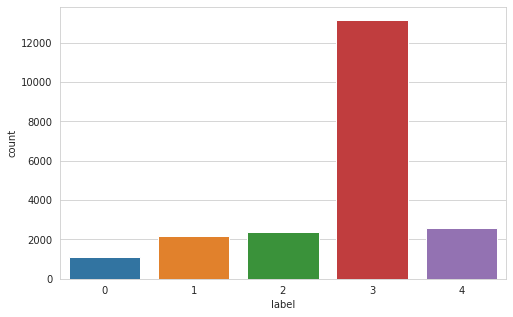

In [ ]:
plt.figure(figsize=(8,5))

sns.set_style('whitegrid')

ax=sns.countplot(data=train_labels, x='label')


#  '0': 'Cassava Bacterial Blight (CBB)
#  '1': 'Cassava Brown Streak Disease (CBSD)
#  '2': 'Cassava Green Mottle (CGM)
#  '3': 'Cassava Mosaic Disease (CMD)
#  '4': 'Healthy

In [ ]:
CLASS_WEIGHT = dict(train_labels.label.value_counts()/train_labels.shape[0])
CLASS_WEIGHT

{0: 0.05080151423096696,
 1: 0.10230406131700706,
 2: 0.11151095948030097,
 3: 0.6149460204701593,
 4: 0.12043744450156564}

## Dividir o conjunto em treino/teste (hold-out)

In [ ]:
x = train_labels.image_id
y = train_labels.label

In [ ]:
# usar o train_test_split para separar um conjunto de dados para teste (hold-out) -> fazer a predição
# proporções 95/5
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = RANDOM_STATE, test_size=0.05)

In [ ]:
# criando um novo df só com (x_train, y_train) para inserir no IMAGEDATAGENERATOR

train_val = {'image_id':x_train,
             'label':y_train}
df_train_val = pd.DataFrame(train_val)
df_train_val.reset_index(drop=True, inplace=True)

df_train_val

,image_id,label
0,3567421807.jpg,4
1,4255258797.jpg,3
2,87295869.jpg,2
3,1696401530.jpg,3
4,484286450.jpg,3
...,...,...
20322,3944665057.jpg,3
20323,791667524.jpg,2
20324,1465491965.jpg,3
20325,4160459669.jpg,3


In [ ]:
# criando um novo df só com (x_test, y_test) para avaliar o modelo com TTA

test_set = {'image_id':x_test,
             'label':y_test}
df_test = pd.DataFrame(test_set)
df_test.reset_index(drop=True, inplace=True)

df_test

,image_id,label
0,1962633596.jpg,1
1,2620830475.jpg,1
2,1284779898.jpg,4
3,2278366099.jpg,3
4,3709090088.jpg,4
...,...,...
1065,455136283.jpg,3
1066,2089510627.jpg,3
1067,1983411262.jpg,4
1068,2454252015.jpg,4


## # Set up variables
We'll set up some of our variables for our notebook here. 

In [ ]:
# target size and number of epochs can be tuned to your needs for obtaining better accuracy

BATCH_SIZE = 8
STEPS_PER_EPOCH = len(df_train_val)*0.8 // BATCH_SIZE
VALIDATION_STEPS = len(df_train_val)*0.2 // BATCH_SIZE
EPOCHS = 15
TARGET_SIZE = 512

CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)

### IMAGEDATAGENERATOR

In [ ]:
df_train_val.label = df_train_val.label.astype('str')

train_datagen = ImageDataGenerator(validation_split = 0.2,
                                     preprocessing_function = None,
                                     rotation_range = 45,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     #vertical_flip = True,
                                     fill_mode = 'nearest',
                                     shear_range = 0.1,
                                     height_shift_range = 0.1,
                                     width_shift_range = 0.1)

train_generator = train_datagen.flow_from_dataframe(df_train_val,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(df_train_val,
                         directory = os.path.join(WORK_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 16262 validated image filenames belonging to 5 classes.
Found 4065 validated image filenames belonging to 5 classes.


## Model

In [ ]:
import tensorflow.keras.applications as all_nn
dir(all_nn)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [ ]:
#Model_0

def build_ResNet50():
    conv_base = all_nn.ResNet50(include_top = False, weights = 'imagenet',
                               input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(5, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)

    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
# EfficientNetB0

def build_efnB0():
    conv_base = all_nn.EfficientNetB0(include_top = False,
                                      weights = 'imagenet',
                                      input_shape = (TARGET_SIZE, TARGET_SIZE, 3))
    # Freeze the pretrained weights
    conv_base.trainable = False
    
    
    # Rebuild top with fine-tuning
    model = conv_base.output
    model = layers.GlobalAveragePooling2D()(model)
    model = layers.Dense(NUM_CLASSES, activation = "softmax")(model)
    model = models.Model(conv_base.input, model)
    
    #Compile
    model.compile(optimizer = Adam(lr = 0.001),
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["acc"])
    return model

In [ ]:
#model_0 = build_ResNet50()

In [ ]:
#model_0.summary()

In [ ]:
#print('Our RestNet50 CNN has %d layers' %len(model1.layers))

In [ ]:
efnB0 = build_efnB0()

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
efnB0.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 512, 512, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 513, 513, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [ ]:
print('Our EfficientNetB0 CNN has %d layers' %len(efnB0.layers))

Our EfficientNetB0 CNN has 239 layers


In [ ]:
model_save = ModelCheckpoint('./EffNetB0_512_8_best_weights.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [ ]:
# Vefificar se GPU esta ativa

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
history = efnB0.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    class_weight=CLASS_WEIGHT,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/15
2032/2032 [==============================] - 1026s 499ms/step - loss: 0.1314 - acc: 0.6571 - val_loss: 0.7942 - val_acc: 0.7200

Epoch 00001: val_loss improved from inf to 0.79417, saving model to ./EffNetB0_512_8_best_weights.h5
Epoch 2/15
2032/2032 [==============================] - 991s 488ms/step - loss: 0.0965 - acc: 0.7291 - val_loss: 0.7266 - val_acc: 0.7458

Epoch 00002: val_loss improved from 0.79417 to 0.72657, saving model to ./EffNetB0_512_8_best_weights.h5
Epoch 3/15
2032/2032 [==============================] - 984s 484ms/step - loss: 0.0903 - acc: 0.7425 - val_loss: 0.7474 - val_acc: 0.7475

Epoch 00003: val_loss did not improve from 0.72657
Epoch 4/15
2032/2032 [==============================] - 985s 485ms/step - loss: 0.0888 - acc: 0.7511 - val_loss: 0.6788 - val_acc: 0.7574

Epoch 00004: val_loss improved from 0.72657 to 0.67880, saving model to ./EffNetB0_512_8_best_weights.h5
Epoch 5/15
2032/2032 [==============================] - 982s 483ms/step - loss: 0

## Evaluating our model

In [ ]:
# print out variables available to us
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


### Learning curves - Graphical evaluation

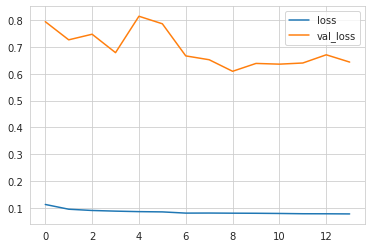

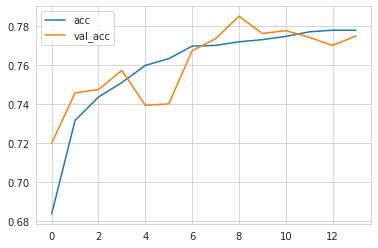

In [ ]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['acc', 'val_acc']].plot();

## Saving the model

In [ ]:
efnB0.save('model_efnB0.h5')

## Making predictions

> ### Preprocess test data

In [ ]:
test_image = []
for i in tqdm(range(x_test.shape[0])):
    img = image.load_img(WORK_DIR+'/train_images'+'/'+df_test['image_id'][i],target_size=(TARGET_SIZE,TARGET_SIZE,3))
    img = image.img_to_array(img)
    test_image.append(img)
X_test = np.array(test_image)

In [ ]:
X_test.shape

(1070, 512, 512, 3)

In [ ]:
y_test = np.array(y_test)
y_test

array([1, 1, 4, ..., 4, 4, 3])

### Define the test Image Generator

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function = None,
                                  rotation_range = 45,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                  #vertical_flip = True,
                                  fill_mode = 'nearest',
                                  shear_range = 0.1,
                                  height_shift_range = 0.1,
                                  width_shift_range = 0.1)

test_generator = test_datagen.flow(X_test,
                                   batch_size=BATCH_SIZE,
                                   shuffle=False)

### TTA

In [ ]:
tta_steps = 4

In [ ]:
predictions = []

for i in tqdm(range(tta_steps)):
    preds = efnB0.predict(test_generator)
    predictions.append(preds)

In [ ]:
final_preds = np.mean(predictions, axis=0)

print(final_preds)
# final_preds determina a classe com maior probabilidade na média

[[2.1222198e-02 1.0580121e-01 1.1303219e-01 2.8801075e-01 4.7193369e-01]
 [1.4798766e-03 1.3897195e-01 1.6089467e-03 7.9268909e-01 6.5250129e-02]
 [6.2827989e-02 2.2757418e-01 6.7593813e-02 4.0570717e-02 6.0143328e-01]
 ...
 [3.1227339e-03 3.8627625e-02 3.4987670e-03 6.6486275e-01 2.8988814e-01]
 [2.7766225e-03 1.0000851e-02 1.7145831e-02 8.1773609e-02 8.8830310e-01]
 [6.5872729e-05 5.1959185e-04 1.4897741e-03 9.9780327e-01 1.2154332e-04]]


## Evaluation

In [ ]:
print(f'Baseline accuracy: {efnB0.evaluate(X_test, y_test)[1]}')

34/34 [==============================] - 12s 306ms/step - loss: 0.6274 - acc: 0.7785
Baseline accuracy: 0.7785046696662903


In [ ]:
print(f'Accuracy with TTA: {np.mean(np.equal(y_test, np.argmax(final_preds, axis=-1)))}')

Accuracy with TTA: 0.7822429906542057
